In [1]:
import PIL
from glob import glob
%matplotlib inline
# Import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf

In [2]:
batch_size = 32
x_train1 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('data/image/cage/*')])/255
x_train2 = np.array([np.array(PIL.Image.open(filename).convert('RGB').resize([64,64])) for filename in glob('data/image/trump/*')])/255
x_valid1 = x_train1[-batch_size:]
x_valid2 = x_train2[-batch_size:]
x_train1 = x_train1[:-batch_size]
x_train2 = x_train2[:-batch_size]
print(x_train1.shape)
print(x_train2.shape)

(286, 64, 64, 3)
(344, 64, 64, 3)


In [3]:
def plot_imgs(imgs, n, title=None):
    fig, axs = plt.subplots(1, n, figsize=(n, 2))
    if n==1:
        axs = [axs]
    for i in range(n):
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    if title is not None:
        fig.suptitle(title)
    plt.show()

In [68]:
class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def build_model(self):
        image_size = self.image_size
        self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
        self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
        self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
        self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')
        def encoder(encoder_input):
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                #hidden = tf.layers.dense(inputs=encoder_input, units=1024, activation=tf.nn.relu)
                #hidden = tf.layers.dense(hidden, units=512, activation=tf.nn.relu)
                #hidden = tf.layers.dense(hidden, units=256, activation=tf.nn.relu)
                #hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=16,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[2,2], strides=[2,2])
                
                hidden = tf.layers.flatten(hidden)
                hidden = tf.layers.dense(hidden, units=1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
            
                self.encoded_embedding = hidden
                
            return hidden
          
        self.encoded_embedding1 = encoder(self.encoder_input1)
        self.encoded_embedding2 = encoder(self.encoder_input2)
        
        def decoder(encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                hidden = tf.layers.dense(inputs=self.encoded_embedding, units = 1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 16384, activation=tf.nn.relu)
                #hidden = tf.layers.dense(inputs=hidden, units = 1024, activation=tf.nn.relu)
                #outputs = tf.layers.dense(inputs=hidden, units = 4096, name = 'recon_logits')
                
                hidden = tf.reshape( hidden, shape=[-1,32,32,16])
                
                hidden = tf.image.resize_images( hidden, size=(64,64))
                
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=16,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                outputs = tf.layers.conv2d(inputs=hidden, filters=3, kernel_size=[3,3], padding='same', activation=None)
                
                return outputs
              
        outputs1 = decoder(self.encoded_embedding1, 'decoder1')
        outputs2 = decoder(self.encoded_embedding2, 'decoder2')
        
        ################## define cost function and optimizer ##################        
        if self.cost_function == 'mse':
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
        elif self.cost_function == 'bce':
            self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
            self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
            self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output1, 
                                                            logits=outputs1))
            self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                            labels=self.decoder_output2, 
                                                            logits=outputs2))
        else:
            self.reconstruct_x1 = outputs1
            self.reconstruct_x2 = outputs2
            self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))
            self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        self.cost = self.cost1 + self.cost2    
        self.lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
        if self.optimizer == 'adadelta':
            self.optimize_op = tf.train.AdadeltaOptimizer(self.lr).minimize(self.cost)
        elif self.optimizer == 'adam':
            self.optimize_op = tf.train.AdamOptimizer(self.lr, beta1=0.5).minimize(self.cost)
        elif self.optimizer == 'rmsprop':
            self.optimize_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.cost)
        else:
            raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in range(n_epoch):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.lr: 5e-5,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
            print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}'.format(
                    epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2)))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
            print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}'.format(
                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2)))
            valid_costs_per_epoch.append(np.mean(valid_costs))
            
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('\nepoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1
            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})

In [69]:
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=0.0001, cost_function='abs')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=20)

epoch0, cost: 0.8576, train_cost1: 0.4723, train_cost2: 0.3853
epoch0, valid_cost: 0.8070, valid_cost1: 0.5010, valid_cost2: 0.3061
epoch1, cost: 0.7151, train_cost1: 0.4496, train_cost2: 0.2655
epoch1, valid_cost: 0.6841, valid_cost1: 0.4608, valid_cost2: 0.2232
epoch2, cost: 0.6037, train_cost1: 0.4014, train_cost2: 0.2023
epoch2, valid_cost: 0.5823, valid_cost1: 0.3924, valid_cost2: 0.1898
epoch3, cost: 0.5191, train_cost1: 0.3374, train_cost2: 0.1817
epoch3, valid_cost: 0.5073, valid_cost1: 0.3266, valid_cost2: 0.1807
epoch4, cost: 0.4653, train_cost1: 0.2920, train_cost2: 0.1734
epoch4, valid_cost: 0.4624, valid_cost1: 0.2888, valid_cost2: 0.1736
epoch5, cost: 0.4308, train_cost1: 0.2654, train_cost2: 0.1654
epoch5, valid_cost: 0.4328, valid_cost1: 0.2678, valid_cost2: 0.1650
epoch6, cost: 0.4055, train_cost1: 0.2467, train_cost2: 0.1589
epoch6, valid_cost: 0.4134, valid_cost1: 0.2538, valid_cost2: 0.1596
epoch7, cost: 0.3929, train_cost1: 0.2391, train_cost2: 0.1538
epoch7, valid

InvalidArgumentError: You must feed a value for placeholder tensor 'encoder_input2' with dtype float and shape [?,64,64,3]
	 [[Node: encoder_input2 = Placeholder[dtype=DT_FLOAT, shape=[?,64,64,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: decoder1/conv2d/BiasAdd/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_118_decoder1/conv2d/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'encoder_input2', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-65828b03e774>", line 4, in <module>
    autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=0.0001, cost_function='abs')
  File "<ipython-input-68-e173c1345236>", line 8, in __init__
    self.build_model()
  File "<ipython-input-68-e173c1345236>", line 13, in build_model
    self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 1734, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 4924, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'encoder_input2' with dtype float and shape [?,64,64,3]
	 [[Node: encoder_input2 = Placeholder[dtype=DT_FLOAT, shape=[?,64,64,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: decoder1/conv2d/BiasAdd/_51 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_118_decoder1/conv2d/BiasAdd", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


### I found that the model above can't run decoder1 and decoder2 seperately, so I make some modify so that I can run reconstruct.

In [99]:
class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def encoder(self, encoder_input):
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
#                print("1st size: ", hidden)
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[2,2], strides=[2,2])
                
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
#                print("2nd size: ", hidden)
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[2,2], strides=[2,2])
                         
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=16,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
#                print("3rd size: ", hidden)
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[1,1], strides=[2,2])
                
                print("before flattren: ", hidden)
                hidden = tf.layers.flatten(hidden)
                hidden = tf.layers.dense(hidden, units=1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
            
                self.encoded_embedding = hidden
                
            return hidden
        
    def decoder(self, encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                hidden = tf.layers.dense(inputs=self.encoded_embedding, units = 1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 32*32*32, activation=tf.nn.relu)              
                hidden = tf.reshape( hidden, shape=[-1,32,32,32])
            
                hidden = tf.image.resize_images( hidden, size=(64,64))
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=16,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
            
                hidden = tf.image.resize_images( hidden, size=(64,64))
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                hidden = tf.image.resize_images( hidden, size=(64,64))
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                outputs = tf.layers.conv2d(inputs=hidden, filters=3, kernel_size=[3,3], padding='same', activation=None)
                
                return outputs
            
    def build_model(self):
        image_size = self.image_size
        
        with tf.name_scope('Decoder1'):
            self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
            self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
          
            self.encoded_embedding1 = self.encoder(self.encoder_input1)
            outputs1 = self.decoder(self.encoded_embedding1, 'decoder1')
            
            ################## define cost function and optimizer ##################        
            if self.cost_function == 'mse':
                self.reconstruct_x1 = outputs1
                self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            elif self.cost_function == 'bce':
                self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
                self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                                labels=self.decoder_output1, 
                                                                logits=outputs1))
            else:
                self.reconstruct_x1 = outputs1
                self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))

    
        with tf.name_scope('Decoder2'):
            self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
            self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')

            self.encoded_embedding2 = self.encoder(self.encoder_input2)
            outputs2 = self.decoder(self.encoded_embedding2, 'decoder2')

            ################## define cost function and optimizer ##################        
            if self.cost_function == 'mse':
                self.reconstruct_x2 = outputs2
                self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
            elif self.cost_function == 'bce':
                self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
                self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                                labels=self.decoder_output2, 
                                                                logits=outputs2))
            else:
                self.reconstruct_x2 = outputs2
                self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        with tf.name_scope('optimizer'):
            self.cost = self.cost1 + self.cost2    
            self.train_lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
            if self.optimizer == 'adadelta':
                self.optimize_op = tf.train.AdadeltaOptimizer(self.train_lr).minimize(self.cost)
            elif self.optimizer == 'adam':
                self.optimize_op = tf.train.AdamOptimizer(self.train_lr, beta1=0.5).minimize(self.cost)
            elif self.optimizer == 'rmsprop':
                self.optimize_op = tf.train.RMSPropOptimizer(self.train_lr).minimize(self.cost)
            else:
                raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in range(n_epoch):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.train_lr: self.lr,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
#            print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}'.format(
#                    epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2)))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
            print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}'.format(
                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2)))
            valid_costs_per_epoch.append(np.mean(valid_costs))
            
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('\nepoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                
#                self.lr *= 0.9
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1
            if counter > 10 and self.lr<5e-6:
                self.lr *= 0.95
            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})

# Architecture
It's interesting to try out several architectures in this assignment, include different kernal number, layer number, different stride, etc. The biggest improvement is when I added the second layer of convlution. <br>
However, isn't the more complex of the model the better, if the model is too deep or too big, it would be hard to train and will produce many redundent or misleading neuron.


# Training
### optimizer
After tring three different optimizer, I found that adam optimizer will decrease loss faster.

### cost function
After tring three differnt cost function, mse, bce and abs, I found think bce and abs would yield better result comparing to mse.  

epoch0, valid_cost: 1.3829, valid_cost1: 0.6924, valid_cost2: 0.6905
epoch1, valid_cost: 1.3609, valid_cost1: 0.6836, valid_cost2: 0.6773
epoch2, valid_cost: 1.3455, valid_cost1: 0.6723, valid_cost2: 0.6732
epoch3, valid_cost: 1.3377, valid_cost1: 0.6673, valid_cost2: 0.6704
epoch4, valid_cost: 1.3359, valid_cost1: 0.6671, valid_cost2: 0.6688
epoch5, valid_cost: 1.3319, valid_cost1: 0.6652, valid_cost2: 0.6667
epoch6, valid_cost: 1.3300, valid_cost1: 0.6653, valid_cost2: 0.6647
epoch7, valid_cost: 1.3236, valid_cost1: 0.6619, valid_cost2: 0.6616
epoch8, valid_cost: 1.3201, valid_cost1: 0.6628, valid_cost2: 0.6573
epoch9, valid_cost: 1.3075, valid_cost1: 0.6570, valid_cost2: 0.6505
epoch10, valid_cost: 1.2925, valid_cost1: 0.6506, valid_cost2: 0.6419
epoch11, valid_cost: 1.2771, valid_cost1: 0.6434, valid_cost2: 0.6337
epoch12, valid_cost: 1.2695, valid_cost1: 0.6401, valid_cost2: 0.6294
epoch13, valid_cost: 1.2622, valid_cost1: 0.6368, valid_cost2: 0.6254
epoch14, valid_cost: 1.2608, v

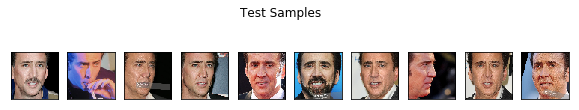

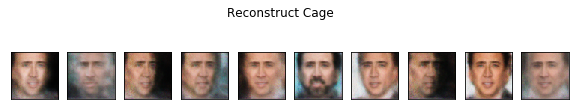

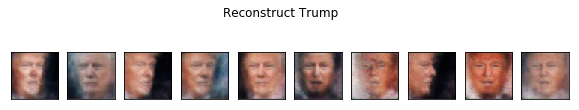

epoch51, valid_cost: 1.1945, valid_cost1: 0.5999, valid_cost2: 0.5946
epoch52, valid_cost: 1.1961, valid_cost1: 0.6004, valid_cost2: 0.5957
epoch53, valid_cost: 1.1928, valid_cost1: 0.5988, valid_cost2: 0.5940
epoch54, valid_cost: 1.1931, valid_cost1: 0.5991, valid_cost2: 0.5940
epoch55, valid_cost: 1.2004, valid_cost1: 0.6025, valid_cost2: 0.5979
epoch56, valid_cost: 1.1907, valid_cost1: 0.5982, valid_cost2: 0.5926
epoch57, valid_cost: 1.1889, valid_cost1: 0.5974, valid_cost2: 0.5915
epoch58, valid_cost: 1.1891, valid_cost1: 0.5973, valid_cost2: 0.5918
epoch59, valid_cost: 1.1875, valid_cost1: 0.5964, valid_cost2: 0.5911
epoch60, valid_cost: 1.1900, valid_cost1: 0.5981, valid_cost2: 0.5919
epoch61, valid_cost: 1.1867, valid_cost1: 0.5958, valid_cost2: 0.5908
epoch62, valid_cost: 1.1894, valid_cost1: 0.5985, valid_cost2: 0.5910
epoch63, valid_cost: 1.1854, valid_cost1: 0.5955, valid_cost2: 0.5899
epoch64, valid_cost: 1.1855, valid_cost1: 0.5950, valid_cost2: 0.5905
epoch65, valid_cost:

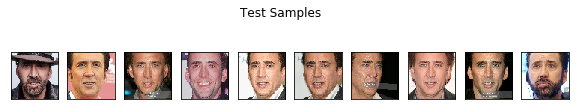

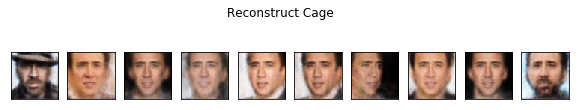

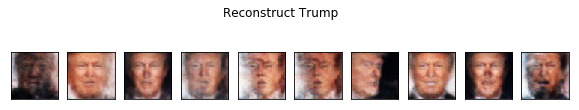

epoch101, valid_cost: 1.1776, valid_cost1: 0.5918, valid_cost2: 0.5858
epoch102, valid_cost: 1.1731, valid_cost1: 0.5900, valid_cost2: 0.5831
epoch103, valid_cost: 1.1737, valid_cost1: 0.5909, valid_cost2: 0.5828
epoch104, valid_cost: 1.1729, valid_cost1: 0.5902, valid_cost2: 0.5827
epoch105, valid_cost: 1.1728, valid_cost1: 0.5899, valid_cost2: 0.5829
epoch106, valid_cost: 1.1783, valid_cost1: 0.5931, valid_cost2: 0.5851
epoch107, valid_cost: 1.1722, valid_cost1: 0.5898, valid_cost2: 0.5824
epoch108, valid_cost: 1.1731, valid_cost1: 0.5901, valid_cost2: 0.5831
epoch109, valid_cost: 1.1721, valid_cost1: 0.5897, valid_cost2: 0.5825
epoch110, valid_cost: 1.1725, valid_cost1: 0.5897, valid_cost2: 0.5827
epoch111, valid_cost: 1.1726, valid_cost1: 0.5897, valid_cost2: 0.5829
epoch112, valid_cost: 1.1721, valid_cost1: 0.5899, valid_cost2: 0.5822
epoch113, valid_cost: 1.1789, valid_cost1: 0.5921, valid_cost2: 0.5868
epoch114, valid_cost: 1.1726, valid_cost1: 0.5897, valid_cost2: 0.5830
epoch1

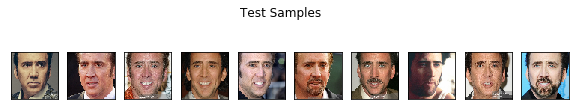

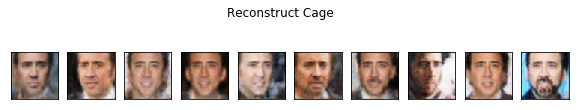

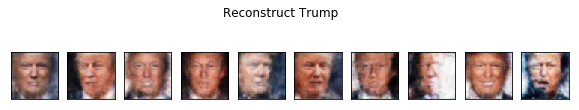

epoch151, valid_cost: 1.1694, valid_cost1: 0.5881, valid_cost2: 0.5813
epoch152, valid_cost: 1.1691, valid_cost1: 0.5879, valid_cost2: 0.5813
epoch153, valid_cost: 1.1730, valid_cost1: 0.5899, valid_cost2: 0.5831
epoch154, valid_cost: 1.1701, valid_cost1: 0.5880, valid_cost2: 0.5820
epoch155, valid_cost: 1.1703, valid_cost1: 0.5883, valid_cost2: 0.5820
epoch156, valid_cost: 1.1704, valid_cost1: 0.5886, valid_cost2: 0.5818
epoch157, valid_cost: 1.1699, valid_cost1: 0.5880, valid_cost2: 0.5820
epoch158, valid_cost: 1.1705, valid_cost1: 0.5887, valid_cost2: 0.5818
epoch159, valid_cost: 1.1690, valid_cost1: 0.5879, valid_cost2: 0.5810
epoch160, valid_cost: 1.1695, valid_cost1: 0.5880, valid_cost2: 0.5815
epoch161, valid_cost: 1.1736, valid_cost1: 0.5896, valid_cost2: 0.5840
epoch162, valid_cost: 1.1696, valid_cost1: 0.5880, valid_cost2: 0.5816
epoch163, valid_cost: 1.1709, valid_cost1: 0.5888, valid_cost2: 0.5820
epoch164, valid_cost: 1.1703, valid_cost1: 0.5883, valid_cost2: 0.5819
epoch1

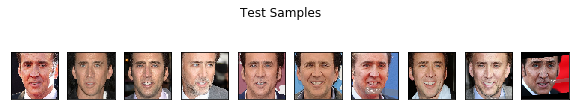

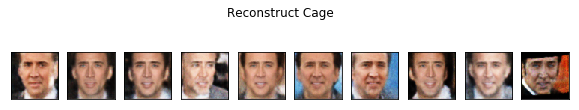

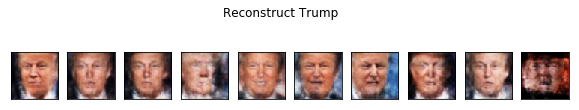

epoch201, valid_cost: 1.1716, valid_cost1: 0.5888, valid_cost2: 0.5828
epoch202, valid_cost: 1.1696, valid_cost1: 0.5877, valid_cost2: 0.5819
epoch203, valid_cost: 1.1723, valid_cost1: 0.5889, valid_cost2: 0.5833
epoch204, valid_cost: 1.1700, valid_cost1: 0.5882, valid_cost2: 0.5818
epoch205, valid_cost: 1.1714, valid_cost1: 0.5888, valid_cost2: 0.5826
epoch206, valid_cost: 1.1693, valid_cost1: 0.5876, valid_cost2: 0.5817
epoch207, valid_cost: 1.1690, valid_cost1: 0.5875, valid_cost2: 0.5815
epoch208, valid_cost: 1.1704, valid_cost1: 0.5878, valid_cost2: 0.5825
epoch209, valid_cost: 1.1714, valid_cost1: 0.5877, valid_cost2: 0.5837
epoch210, valid_cost: 1.1709, valid_cost1: 0.5884, valid_cost2: 0.5826
epoch211, valid_cost: 1.1698, valid_cost1: 0.5875, valid_cost2: 0.5822
epoch212, valid_cost: 1.1706, valid_cost1: 0.5884, valid_cost2: 0.5822
epoch213, valid_cost: 1.1699, valid_cost1: 0.5875, valid_cost2: 0.5824
epoch214, valid_cost: 1.1733, valid_cost1: 0.5892, valid_cost2: 0.5842
epoch2

In [93]:
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=5e-5, cost_function='bce')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=40)

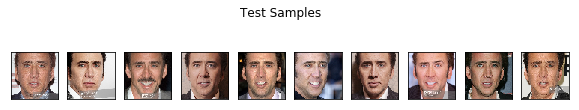

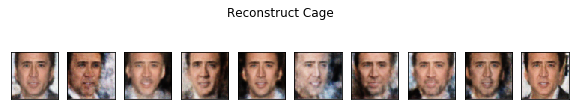

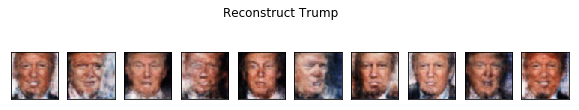

In [94]:
n = 10
orig_imgs = x_valid1[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
    
plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

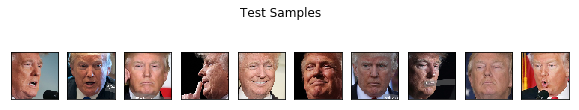

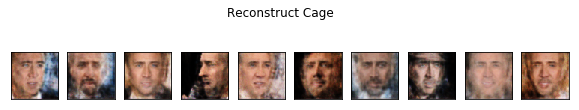

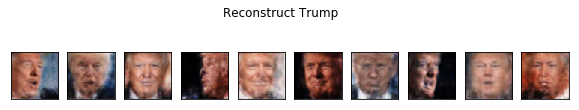

In [95]:
n = 10
orig_imgs = x_valid2[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

## Only two layers of Conv

In [162]:
class AutoEncoder(object):
    def __init__(self, image_size, lr=0.001, cost_function='bce', optimizer='adadelta'):
        
        self.image_size = image_size
        self.lr = lr # learning rate
        self.cost_function = cost_function
        self.optimizer = optimizer
        self.build_model()
        
    def encoder(self, encoder_input):
            with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                print("1st size: ", hidden)
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[2,2], strides=[2,2])
                
                hidden = tf.layers.conv2d( inputs=encoder_input, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                print("2nd size: ", hidden)
                hidden = tf.layers.max_pooling2d( inputs=hidden, pool_size=[2,2], strides=[2,2])
                
                print("before flattren: ", hidden)
                hidden = tf.layers.flatten(hidden)
                hidden = tf.layers.dense(hidden, units=1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(hidden, units=64, activation=tf.nn.relu)
            
                self.encoded_embedding = hidden
                
            return hidden
        
    def decoder(self, encoded_embedding, scope_name):   
            with tf.variable_scope(scope_name): 
                hidden = tf.layers.dense(inputs=self.encoded_embedding, units = 1024, activation=tf.nn.relu)
                hidden = tf.layers.dense(inputs=hidden, units = 32*32*32, activation=tf.nn.relu)              
                hidden = tf.reshape( hidden, shape=[-1,32,32,32])
            
                hidden = tf.image.resize_images( hidden, size=(64,64))
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                hidden = tf.image.resize_images( hidden, size=(64,64))
                hidden = tf.layers.conv2d_transpose( inputs=hidden, filters=32,
                                          kernel_size=[3, 3], padding="same", activation=tf.nn.relu)
                
                outputs = tf.layers.conv2d(inputs=hidden, filters=3, kernel_size=[3,3], padding='same', activation=None)
                
                return outputs
            
    def build_model(self):
        image_size = self.image_size
        
        with tf.name_scope('Decoder1'):
            self.encoder_input1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input1')
            self.decoder_output1 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output1')
          
            self.encoded_embedding1 = self.encoder(self.encoder_input1)
            outputs1 = self.decoder(self.encoded_embedding1, 'decoder1')
            
            ################## define cost function and optimizer ##################        
            if self.cost_function == 'mse':
                self.reconstruct_x1 = outputs1
                self.cost1 = tf.reduce_mean(tf.pow(self.decoder_output1-outputs1, 2))
            elif self.cost_function == 'bce':
                self.reconstruct_x1 = tf.nn.sigmoid(outputs1)
                self.cost1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                                labels=self.decoder_output1, 
                                                                logits=outputs1))
            else:
                self.reconstruct_x1 = outputs1
                self.cost1 = tf.reduce_mean(tf.abs(self.decoder_output1-outputs1))

    
        with tf.name_scope('Decoder2'):
            self.encoder_input2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='encoder_input2')
            self.decoder_output2 = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 3], name='decoder_output2')

            self.encoded_embedding2 = self.encoder(self.encoder_input2)
            outputs2 = self.decoder(self.encoded_embedding2, 'decoder2')

            ################## define cost function and optimizer ##################        
            if self.cost_function == 'mse':
                self.reconstruct_x2 = outputs2
                self.cost2 = tf.reduce_mean(tf.pow(self.decoder_output2-outputs2, 2))
            elif self.cost_function == 'bce':
                self.reconstruct_x2 = tf.nn.sigmoid(outputs2)
                self.cost2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                                                                labels=self.decoder_output2, 
                                                                logits=outputs2))
            else:
                self.reconstruct_x2 = outputs2
                self.cost2 = tf.reduce_mean(tf.abs(self.decoder_output2-outputs2))
            
        with tf.name_scope('optimizer'):
            self.cost = self.cost1 + self.cost2    
            self.train_lr = tf.Variable(self.lr, trainable=False, name='learning_rate')
            if self.optimizer == 'adadelta':
                self.optimize_op = tf.train.AdadeltaOptimizer(self.train_lr).minimize(self.cost)
            elif self.optimizer == 'adam':
                self.optimize_op = tf.train.AdamOptimizer(self.train_lr, beta1=0.5).minimize(self.cost)
            elif self.optimizer == 'rmsprop':
                self.optimize_op = tf.train.RMSPropOptimizer(self.train_lr).minimize(self.cost)
            else:
                raise NotImplementedError
            
    def train(self, sess, x_train1, x_train2, x_train1_output, x_train2_output, 
              x_valid1, x_valid2, x_valid1_output, x_valid2_output, n_epoch=200, batch_size=100, patience=5):
        t0 = time()
        train_costs_per_epoch = []
        valid_costs_per_epoch = []
        best_cost = np.inf
        counter = 0
        def iter_data(*data, **kwargs):
            size = kwargs.get('batch_size', 32)
            try:
                n = len(data[0])
            except:
                n = data[0].shape[0]
            batches = int(n / size)
            if n % size != 0:
                batches += 1

            for b in range(batches):
                start = b * size
                end = (b + 1) * size
                if end > n:
                    end = n
                if len(data) == 1:
                    yield data[0][start:end]
                else:
                    yield tuple([d[start:end] for d in data])
        for epoch in range(n_epoch):
            t = time()
            data_to_use = min(len(x_train1), len(x_train2))
            shuffle_idx = np.random.permutation(len(x_train1))
            x_train1 = x_train1[shuffle_idx][:data_to_use]
            x_train1_output = x_train1_output[shuffle_idx][:data_to_use]
            shuffle_idx = np.random.permutation(len(x_train2))
            x_train2 = x_train2[shuffle_idx][:data_to_use]
            x_train2_output = x_train2_output[shuffle_idx][:data_to_use]
            train_costs1 = []
            train_costs2 = []
            train_costs = []
            valid_costs1 = []
            valid_costs2 = []
            valid_costs = []
            
            # train
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_train1, x_train2, x_train1_output, x_train2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                    self.train_lr: self.lr,
                }
                _, cost1, cost2, cost = sess.run([self.optimize_op, self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                train_costs1.append(cost1)
                train_costs2.append(cost2)
                train_costs.append(cost)
#            print('epoch{}, cost: {:.4f}, train_cost1: {:.4f}, train_cost2: {:.4f}'.format(
#                    epoch, np.mean(train_costs), np.mean(train_costs1), np.mean(train_costs2)))
            train_costs_per_epoch.append(np.mean(train_costs))
            
            # validation
            for input1_batch, input2_batch, output1_batch, output2_batch in iter_data(x_valid1, x_valid2, x_valid1_output, x_valid2_output, batch_size=batch_size):
                feed_dict = {
                    self.encoder_input1: input1_batch, 
                    self.decoder_output1: output1_batch,
                    self.encoder_input2: input2_batch, 
                    self.decoder_output2: output2_batch,
                }
                cost1, cost2, cost = sess.run([self.cost1, self.cost2, self.cost], feed_dict=feed_dict)
                valid_costs1.append(cost1)
                valid_costs2.append(cost2)
                valid_costs.append(cost)
#            print('epoch{}, valid_cost: {:.4f}, valid_cost1: {:.4f}, valid_cost2: {:.4f}'.format(
#                   epoch, np.mean(valid_costs), np.mean(valid_costs1), np.mean(valid_costs2)))
            valid_costs_per_epoch.append(np.mean(valid_costs))
            
            # for every 50 epoch, plot image
            if epoch > 0 and epoch % 50 == 0:
                print('\nepoch: {}'.format(epoch))
                n = 10
                orig_imgs = x_train1[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                plot_imgs(orig_imgs, n=n, title='Test Samples')
                plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
                plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

                orig_imgs = x_train2[:n]
                recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
                min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(min_value < 0, recon_imgs-min_value, recon_imgs)
                max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
                recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)
                recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
                min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(min_value < 0, recon_imgs2-min_value, recon_imgs2)
                max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
                recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
                
#                self.lr *= 0.9
                
            # early stop
            if best_cost > np.mean(valid_costs):
                best_cost = np.mean(valid_costs)
                counter = 0
            else:
                counter += 1

            if counter >= patience:
                print('early stop at {} epoch'.format(epoch))
                break
        return train_costs_per_epoch, valid_costs_per_epoch
            
    def encode(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.encoded_embedding1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.encoded_embedding2, feed_dict={self.encoder_input2: inputs})
          
    def reconstruct(self, sess, inputs, use_decoder1=True):
        if use_decoder1:
            return sess.run(self.reconstruct_x1, feed_dict={self.encoder_input1: inputs})
        else:
            return sess.run(self.reconstruct_x2, feed_dict={self.encoder_input2: inputs})

1st size:  Tensor("Decoder1/encoder/conv2d/Relu:0", shape=(?, 64, 64, 32), dtype=float32)
2nd size:  Tensor("Decoder1/encoder/conv2d_1/Relu:0", shape=(?, 64, 64, 32), dtype=float32)
before flattren:  Tensor("Decoder1/encoder/max_pooling2d_1/MaxPool:0", shape=(?, 32, 32, 32), dtype=float32)
1st size:  Tensor("Decoder2/encoder/conv2d/Relu:0", shape=(?, 64, 64, 32), dtype=float32)
2nd size:  Tensor("Decoder2/encoder/conv2d_1/Relu:0", shape=(?, 64, 64, 32), dtype=float32)
before flattren:  Tensor("Decoder2/encoder/max_pooling2d_1/MaxPool:0", shape=(?, 32, 32, 32), dtype=float32)

epoch: 50


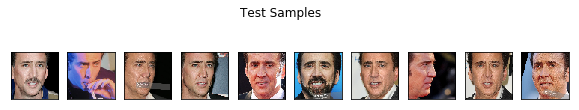

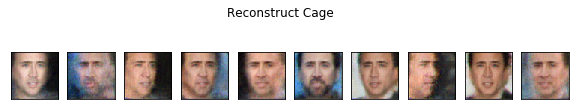

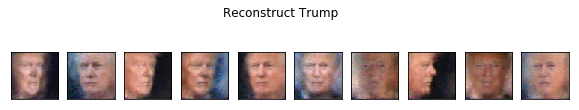


epoch: 100


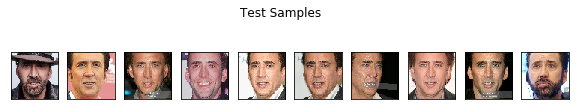

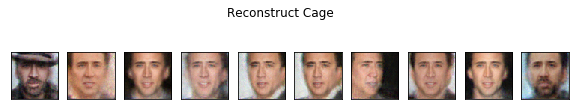

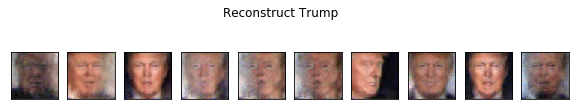


epoch: 150


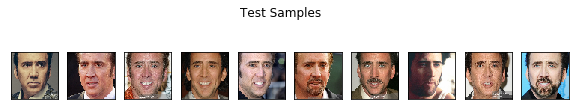

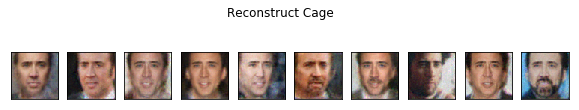

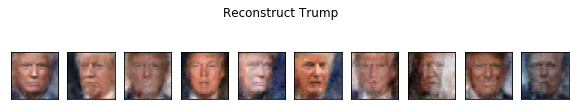


epoch: 200


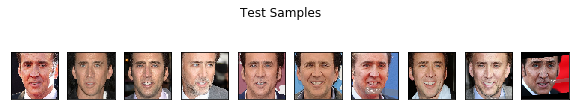

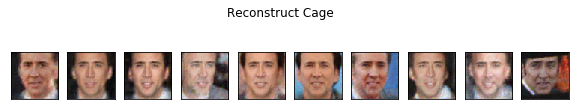

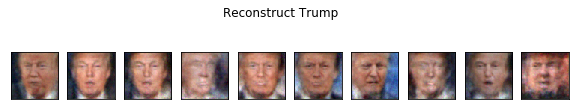

early stop at 236 epoch


In [164]:
tf.reset_default_graph()
np.random.seed(123)
tf.set_random_seed(123)
autoencoder = AutoEncoder(image_size=64, optimizer='adam', lr=5e-5, cost_function='abs')

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
train_costs_per_epoch = autoencoder.train(sess, x_train1, x_train2, x_train1, x_train2, 
                                          x_valid1, x_valid2, x_valid1, x_valid2, n_epoch=1000, batch_size=batch_size, patience=50)

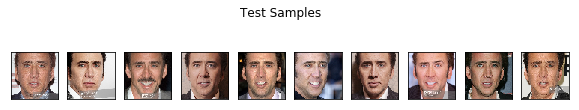

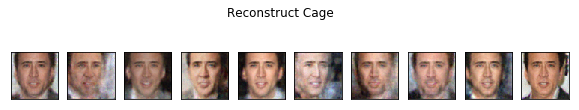

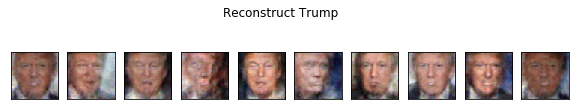

In [165]:
n = 10
orig_imgs = x_valid1[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)
    
plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

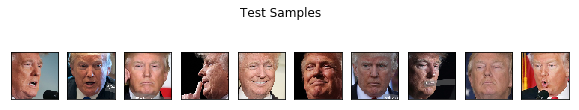

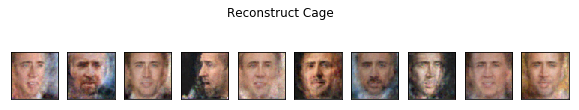

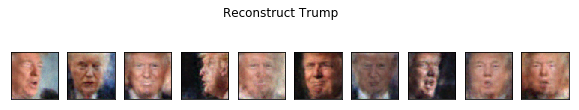

In [166]:
n = 10
orig_imgs = x_valid2[:n]

recon_imgs = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=True)
min_value = np.min(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(min_value < 0, recon_imgs - min_value, recon_imgs)
max_value = np.max(recon_imgs, axis=(1,2,3), keepdims=True)
recon_imgs = np.where(max_value > 1, recon_imgs/max_value, recon_imgs)

recon_imgs2 = autoencoder.reconstruct(sess, orig_imgs, use_decoder1=False)
min_value = np.min(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(min_value < 0, recon_imgs2 - min_value, recon_imgs2)
max_value = np.max(recon_imgs2, axis=(1,2,3), keepdims=True)
recon_imgs2 = np.where(max_value > 1, recon_imgs2/max_value, recon_imgs2)

plot_imgs(orig_imgs, n=n, title='Test Samples')
plot_imgs(recon_imgs, n=n, title='Reconstruct Cage')
plot_imgs(recon_imgs2, n=n, title='Reconstruct Trump')

# Application of AutoEncoder

### As Preprocessor
<p>Due to the characteristic of Autoencoder, it is often used in Deep learning for feature extraction, which could simplify the complexity of data, and denoising, which would ignore misleding information during decode.</p>

### Other Application
<p>From this assignment, I think we could use autoencoder for 
    <ol>
        <li> Face swap, that is similiar to what we did in this DeepFake model</li>
        <li> Face touch up(美肌), remove defect of ones face</li>
        <li> Changing color or texture of an image </li>
    </ol>
</p>